In [1]:
"""
Written by Ashley Ashiku, telescope engineer, for PULSE-A project.

Utilizes code written by Prof. Bradford Benson for the ASTR 212 class and Prof. Andrey Kravtsov for the ASTR 211 
class.

Last updated July 15, 2025.

"""

'\nWritten by Ashley Ashiku, telescope engineer, for PULSE-A project.\n\nUtilizes code written by Prof. Bradford Benson for the ASTR 212 class and Prof. Andrey Kravtsov for the ASTR 211 \nclass.\n\nLast updated July 15, 2025.\n\n'

Here is the image info:

Filename: /Users/ashleyashiku/Desktop/PULSE-A/cameratest/test1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (4656, 3520)   uint8   

here is the header:
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 4656                                                  NAXIS2  =                 3520                                                  EXTEND  =                    T                                                  END                                                                                                                                                                                                                                                                                   

'\nAs you can see, this image was not taken at "infinity" and is not focused properly.\n'

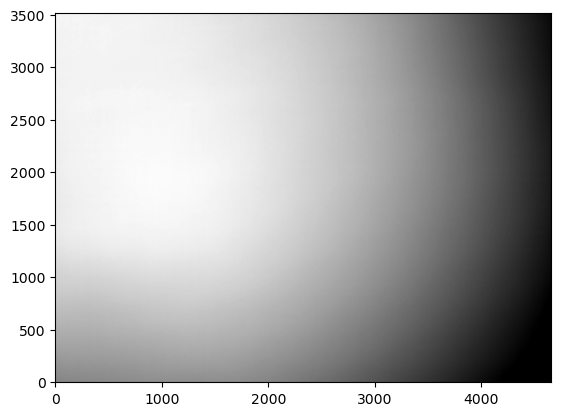

In [3]:
# necessary imports
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import stats
from scipy.stats import norm
from IPython.display import Image
%matplotlib inline

# define pathname to the image you are trying to open
image = fits.open('/Users/ashleyashiku/Desktop/PULSE-A/cameratest/test1.fits')

# open and define the header and actual "image" data
header = image[0].header
imagedata = image[0].data

# visual sanity check for us
print("Here is the image info:")
print()
image.info()
print()

print(f"here is the header:")
print(header)
print()

print("Here are the pixel dimensions:")
print(imagedata.shape)
print()

# now, let's flatten the data so we can access the counts of each pixel
counts = imagedata.flatten()

# another sanity check, look at the max and min count values
print(f"Max count: {np.max(counts)}")
print(f"Min count: {np.min(counts)}")

# display image for us to see
plt.imshow(imagedata, cmap = "gray", vmin = np.percentile(imagedata,1.),
          vmax = np.percentile(imagedata, 99.) , origin = "lower", aspect='auto')

"""
As you can see, this image was not taken at "infinity" and is not focused properly.
"""

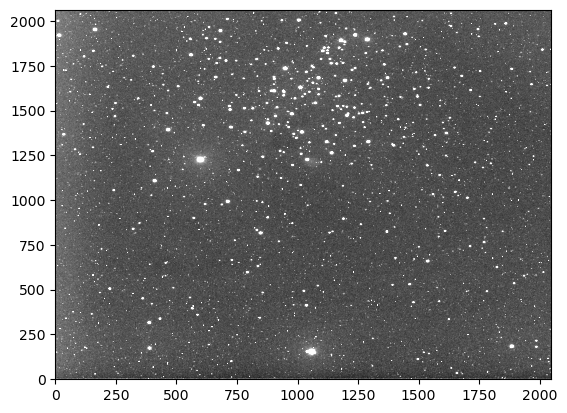

In [4]:
"""
I'm going to display another astronomical image I took in a class (ASTR 212) for display purposes.
This is what a raw, uncalibrated image looks like.
""" 
# titled raw because it's a raw, unedited, uncalibrated image

raw = fits.open("test_imgs/RAW.fits") 
rawdata = raw[0].data # don't forget this step!
countvalues = rawdata.flatten() # remember i'm flattening here to work with the actual pixel counts

plt.imshow(rawdata, cmap = "gray", vmin = np.percentile(rawdata,1.),
          vmax = np.percentile(rawdata, 99.) , origin = "lower", aspect='auto')


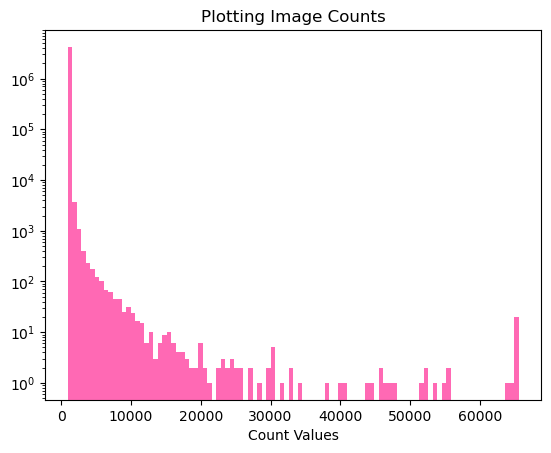

In [5]:
"""
Great, now we're going to work with the actual "counts" per image pixel. Remember how CCDs/CMOS detectors work-- 
roughly, photons hitting each pixel trigger the release of an electron. The analog to digital converter counts the
number of electrons in each pixel, which gets translated to "counts". The "gain" of a camera dictates the conversion
ratio here. If gain = 0, then 1 electron = 1 count. But if you increase the gain, it's going to look more like 
1 electron = 20 counts. This is beneficial if you're observing a very very tiny change in light. 

So we're currently looking at the counts, which you can think of roughly as the photons hitting the detectors because
in this example the gain = 0.
"""
plt.hist(countvalues, bins=100, color = "hotpink")
plt.yscale('log')
plt.xlabel("Count Values")
plt.title("Plotting Image Counts")
plt.show()

(3520, 4656)
(16389120,)


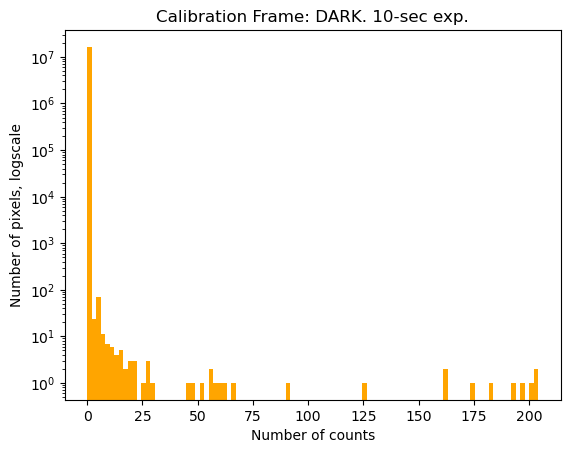

In [6]:
"""
Great, now we start the calibration process. First is the dark frame, which is exactly what it sounds like. We take
an image while covering the camera's aperture so *no light can enter*. An important step is that we take this dark 
frame using the same exposure time we will be using during our actual observations.

So if we're taking 2 second exposures of the ISS, we need to take 2 second dark frames. Theoretically, this image
should be perfectly dark and the count value of each pixel should equal 0.

But in the real world, that's not how it happens. Dark current and thermal noise occurs-- the easiest way to think
about it is that the camera heats up while taking images and these electrons are still read as "counts" even though 
they're not actually light.

Longer exposure times recieve more thermal noise.
"""

# Here is the code I used for the calibration images I took for my tests with the PULSE-A camera
# As you can see, while the vast majority of pixels record 0 counts (no light) correctly, some still record light
darkframe = fits.open('/Users/ashleyashiku/Desktop/PULSE-A/cameratest/may4_DARK-10sec.fits')
darkdata = darkframe[0].data
print(darkdata.shape)
darkcounts = darkdata.flatten()
print(darkcounts.shape)

plt.figure()

_ = plt.hist(darkcounts, bins=100, color = "orange")
plt.yscale('log')
plt.title("Calibration Frame: DARK. 10-sec exp.")
plt.xlabel("Number of counts")
plt.ylabel("Number of pixels, logscale")
plt.show()


(3520, 4656)
(16389120,)


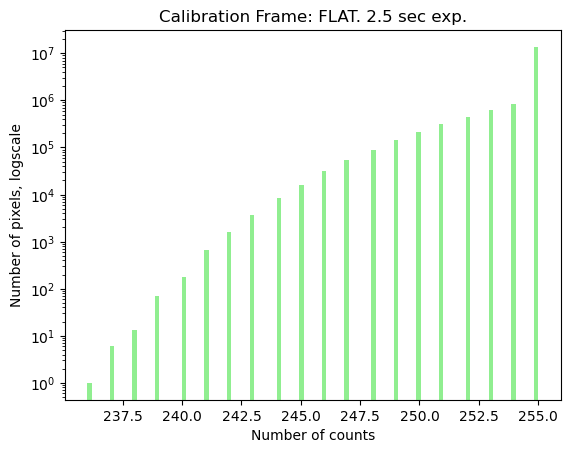

In [7]:
"""
In a flat frame, you take an image of a uniformally bright surface. The idea is that all pixels should record an 
equal amount of counts since they all receive the same amount of light.

The flat frame's purpose is to exposure the varying sensitivity of each pixel. You can see that in this flat frame
I took, while all pixels recieved the same amount of light (255 counts), many pixels are less sensitive and 
recorded less counts than that.
"""

flatframe = fits.open('/Users/ashleyashiku/Desktop/PULSE-A/cameratest/may4_FLAT-2.5sec.fits')
flatdata = flatframe[0].data
print(flatdata.shape)
flatcounts = flatdata.flatten()
print(flatcounts.shape)

plt.figure()

_ = plt.hist(flatcounts, bins=100, color = "lightgreen")
plt.yscale('log')
plt.title("Calibration Frame: FLAT. 2.5 sec exp.")
plt.xlabel("Number of counts")
plt.ylabel("Number of pixels, logscale")
plt.show()

(3520, 4656)
(16389120,)


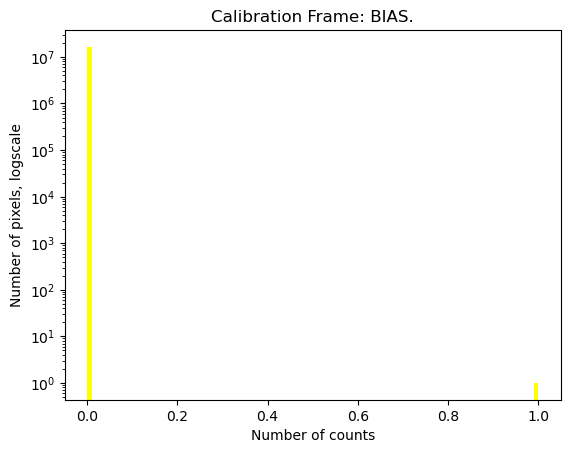

In [8]:
"""
Our last calibration frame is called the bias frame. This is a "0 second" exposure (we usually just take the 
shortest exposure time that a camera offers but keep the aperture covered so no light comes in). The purpose of this
frame is to identify hot pixels: fried pixels that are constantly recording light even when there is none.

You can see here that in this image I took, I recorded one hot pixel in the camera.
"""
biasframe = fits.open('/Users/ashleyashiku/Desktop/PULSE-A/cameratest/may4_BIAS.fits')
biasdata = biasframe[0].data
print(biasdata.shape)
biascounts = biasdata.flatten()
print(biascounts.shape)

plt.figure()

_ = plt.hist(biascounts, bins=100, color = "yellow")
plt.yscale('log')
plt.title("Calibration Frame: BIAS.")
plt.xlabel("Number of counts")
plt.ylabel("Number of pixels, logscale")
plt.show()

In [13]:
"""
Now, onto the calibration process! Since my personal images with the tracking camera were not properly converged, 
I am using the raw image I took as part of ASTR 212 and the calibration frames that were provided to us there to 
demonstrate.


Let's define the frames I'm using. For the raw image, I'm using the same sky image I took in ASTR 212 and defined
earlier as "rawdata".

I'm redefining the calibration frames! Let's also print them out so you can see what they look like.
""" 
dark_ex = fits.open('/Users/ashleyashiku/Desktop/ASTR212/DARK.fits')
darkdata = dark_ex[0].data

bias_ex = fits.open('/Users/ashleyashiku/Desktop/ASTR212/BIAS.fits')
biasdata = bias_ex[0].data

flat_ex = fits.open('/Users/ashleyashiku/Desktop/ASTR212/g-bandFLAT.fits')
flatdata = flat_ex[0].data

Here is the dark frame.

REMEMBER:
 !!!! THESE ARE NOT STARS !!!! 

 THESE SPOTS OF LIGHT ARE ELECTRONIC & READ OUT NOISE FROM THE CAMERA !!


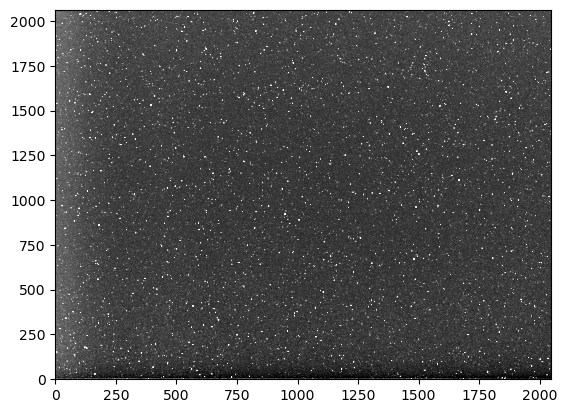

In [25]:
print("Here is the dark frame.")
print()
print("REMEMBER:")
print(" !!!! THESE ARE NOT STARS !!!! ")
print()
print(" THESE SPOTS OF LIGHT ARE ELECTRONIC & READ OUT NOISE FROM THE CAMERA !!")
_ = plt.imshow(darkdata, cmap = "gray", vmin = np.percentile(darkdata,1.),
          vmax = np.percentile(darkdata, 99.) , origin = "lower", aspect='auto')

Here is the flat frame.


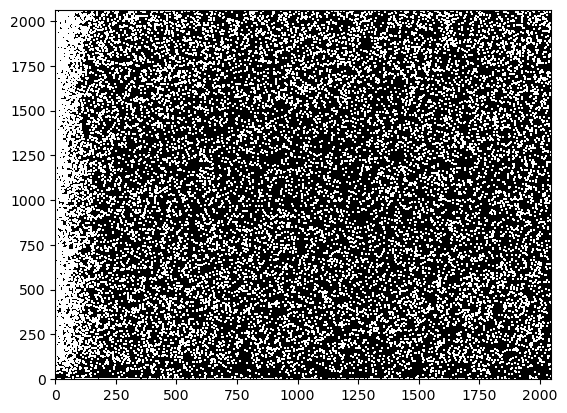

In [21]:
print("Here is the flat frame.")
_ = plt.imshow(flatdata, cmap = "gray", vmin = np.percentile(flatdata,1.),
          vmax = np.percentile(flatdata, 99.) , origin = "lower", aspect='auto')

Here is the bias frame.


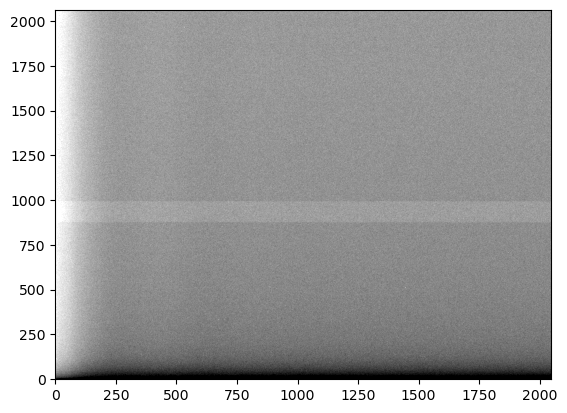

In [20]:
print("Here is the bias frame.")
_ = plt.imshow(biasdata, cmap = "gray", vmin = np.percentile(biasdata,1.),
          vmax = np.percentile(biasdata, 99.) , origin = "lower", aspect='auto')

In [37]:
# start calibrating calibration frames

# normalize flat
flatnorm = flatdata/(np.mean(flatdata))
finalcal = (rawdata - biasdata - darkdata)/flatnorm

"""
The calibration frames from class aren't perfect but I don't want to spend time debugging it! This is the general
equation you would use though.
"""

"\nThe calibration frames from class aren't perfect but I don't want to spend time debugging it! This is the general\nequation you would use though.\n"

In [1]:
#plt.imshow(rawdata, cmap='gray', origin='lower', vmin=np.percentile(finalcal, 1), vmax=np.percentile(finalcal, 99))
#plt.colorbar(label="Pixel Value")
#plt.title("Raw Image (10sec 'pointsource')")
#plt.show()

In [14]:
# here, i am importing Professor Andrey Kravtsov's code for my plots. It makes them visually appealing!
# import relevant packages

import matplotlib.pyplot as plt
import numpy as np 

# the following commands make plots look better
def plot_prettier(dpi=150, fontsize=11, usetex=False): 
    '''
    Make plots look nicer compared to Matplotlib defaults
    Parameters: 
        dpi - int, "dots per inch" - controls resolution of PNG images that are produced
                by Matplotlib
        fontsize - int, font size to use overall
        usetex - bool, whether to use LaTeX to render fonds of axes labels 
                use False if you don't have LaTeX installed on your system
    '''
    plt.rcParams['figure.dpi']= dpi
    plt.rc("savefig", dpi=dpi)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in') 
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    if usetex:
        plt.rc('text', usetex=usetex)
    else:
        plt.rcParams['mathtext.fontset'] = 'cm'
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
        

plot_prettier(dpi=150, fontsize=11)